# Traffic Optimization Using Deep Reinforcement Learning

### Task 5

Full assignment: https://gist.github.com/RafalKucharskiPK/c3bc960f047829569808ccbcffc3b8ce

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import time

# Introduction

In this part of the work, the system is slighlty modified so it will be ideal for a solution using deep reinforcement learning techniques. Previously, we have seen how can the initial problem can be modeled and resolved as a RL problem, and this time, we will go one step further by increasing the system complexity and demonstrate a more sophisticated solution. We will see if under added complexities, a deep RL model can provide any improvements.

## System Description

### Added Complexity

The environment now consists of 3 routes, connecting the origin to the destination. Also we have a randomness factor to it, which increases the congestions by a little bit occasionally.

### Episode

An episode consists set number of steps, each of them is a vehicle choosing a route. The episode is finalized when all vehicles are on a route.

### Environment

The environment is modeled as a traffic system consisting of three routes (A, B, C) connecting an origin to a destination. Each route has a different capacity and free-flow speed:

- **Route A**: Capacity = 20, Free-flow travel time = 5
- **Route B**: Capacity = 25, Free-flow travel time = 8
- **Route C**: Capacity = 40, Free-flow travel time = 11

The system operates with a set of vehicles and introduces stochasticity (`randomness = 0.05`) to represent real-world uncertainties such as weather conditions.
Number of vehicles is set to 50 for this implementation. For this time, we focused solely on if our implementation can offer any improvements to the initial case. One can simply increase the number of vehicles and rerun the code for a more realistic scenerio, at expense of more training time.

### Problem as a RL Task

The system can be seen as the playground of a central traffic management agent, or a set of agents trying to get to their destination as fast as possible, sharing a common knowledge. At each step, the agent is responsible for selecting one of the three routes to reach its destination. 
- The **state** space is a vector comprising the current traffic on each route and the occurrence of random events. 
- The **action** space contains three discrete actions corresponding to the choice of the route. It is selected from `0, 1, 2`, correspond to routes A, B or C respectively.
- The **reward function** is designed to penalize longer travel times while balancing the load among the routes. At each step for the given route selection x, reward is $t_x(q_x)$ on that route where $q_x$ is the current traffic. Thanks to this, it is aimed to enable the agent to pick the fastest route at each step. In the code, there is also a jackpot reward disabled, which one can enable back, which rewards if the travel times on all routes are equalized.

### Algorithms and Methods

We employ a **Deep Q-Network (DQN)** with ***experience replay*** for training each agent. Key hyperparameters are:

- `batch_size = 8`: Number of experiences used in each training iteration
- `num_episodes = 500`: Total number of episodes for training
- `gamma = 0.8`: Discount factor
- `epsilon = 1.0`: Initial exploration rate
- `epsilon_decay = 0.99`: Epsilon decay applied at each episode

The neural network architecture consists of two hidden layers and employs Mean Squared Error (MSE) as the loss function. As the name of the method suggests, **the network yields the Q-value estimations of each possible action given the state**.

## Complexity

The primary computational complexities stem from:

1. **Neural Network Training**: The DQN agent uses a fully connected neural network with two hidden layers, making the training complexity $O(n^2)$ for $n$ neurons.
2. **Experience Replay**: The complexity for experience replay is $O(n \times m)$ for $n$ experiences and $m$ batch size.
3. **Episodes and Actions**: The total number of actions performed is $num\_episodes \times num\_vehicles$.

## Space Complexity

1. **Experience Memory**: 
    - The agent stores state, action, reward, and next_state, each of which is a vector or scalar. Given that we store these values for each vehicle for every episode, for $n$ experiences, the space complexity is $O(4 \times num\_vehicles \times num\_episodes)$.

2. **Q-Table Approximation**:
    - The neural network itself is a function approximator for the Q-table. With $n_1$ and $n_2$ neurons in the hidden layers, the space required to store the weights and biases is $O(n_1 + n_1 \times n_2 + n_2)$.



## Results

The agent successfully navigated the environment with increasing cumulative rewards over episodes, thus demonstrating the ability to learn optimal policies for traffic management. Results are illustrated with rewards and final states at regular intervals.
As one can see, the training still seems to be in an unstable trend. This can be because of the ongoing convergence, or an effect of stochastic nature of the environment. Either way, one can explore where does this training go if given more time.

# Parameters

In [2]:
num_vehicles = 50

# Route capacities
capacity_a = 20
capacity_b = 25
capacity_c = 40

# Free flow speed on routes
t0_a = 5
t0_b = 8
t0_c = 11

# Randomness on city traffic
randomness = 0.05

In [3]:
batch_size = 8 # For DQN Training
num_episodes = 500

# Classes

In [4]:
class TrafficEnv:

    def __init__(self, capacity_a, capacity_b, capacity_c, t0_a, t0_b, t0_c, randomness):

        # Route capacities
        self.capacities = [capacity_a, capacity_b, capacity_c]
        # Free flow speed
        self.free_flows = [t0_a, t0_b, t0_c]
        # Initial traffic
        self.traffic_on_roads = [0, 0, 0]
        # Random events on roads
        self.randomness = randomness

        self.travel_time = lambda q_x, t0_x, Q_x: t0_x * (1 + pow(q_x/Q_x, 2))


    def step(self, action):

        road_index = action
        self.traffic_on_roads[road_index] += 1

        random_event = self.get_random_events()
        reward = self.get_reward(road_index, random_event)

        state = np.array([self.traffic_on_roads[0], self.traffic_on_roads[1], self.traffic_on_roads[2], random_event])

        return state, reward


    def get_reward(self, road_index, random_event):
        travel_times = self.get_travel_times()

        if random_event == 1:
            for i in range(len(travel_times)):
                travel_times[i] += 3

        reward = -1 * travel_times[road_index]

        # if agent arranged the travel times on each route equally, jackpot
        #if (travel_times[0] == travel_times[1]) and (travel_times[1] == travel_times[2]):
        #  reward += 10

        return reward


    def get_random_events(self): # Rain, accidents, disasters, etc.
        return int(random.random() < self.randomness)


    def get_travel_times(self):
        return [self.travel_time(self.traffic_on_roads[x], self.free_flows[x], self.capacities[x]) for x in range(len(self.traffic_on_roads))]


    def reset(self):
        self.traffic_on_roads = [0, 0, 0]
        initial_state = np.array([self.traffic_on_roads[0], self.traffic_on_roads[1], self.traffic_on_roads[2], 0])
        return initial_state


In [5]:
class DQN_TrafficAgent:

    def __init__(self, state_size, action_size, batch_size, gamma = 0.8, epsilon = 1.0, epsilon_min = 0, epsilon_decay = 0.99):

        self.state_size = state_size
        self.action_size = action_size

        self.memory = list()
        self.batch_size = batch_size

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.model = self.build_model()


    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(self.state_size * 2, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(self.state_size * 4, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.003))
        return model


    def remember(self, state, action, reward, next_state): # Cache events
        self.memory.append((state, action, reward, next_state))


    def pick_action(self, state):
        if np.random.rand() <= self.epsilon: # Explore
            action = random.randrange(self.action_size)
            return action

        act_values = self.model.predict(state, verbose=0)[0]
        action = np.argmax(act_values)
        return action


    def replay(self):
        # Do we have enough cache to train our network?
        if len(self.memory) < self.batch_size: return

        minibatch = random.sample(self.memory, batch_size)
        states = np.array([x[0][0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3][0] for x in minibatch])

        best_future = np.amax(self.model.predict(next_states, batch_size=self.batch_size, verbose=0), axis=1)
        target = rewards + (self.gamma * best_future)
        target_full = self.model.predict(states, batch_size=self.batch_size, verbose=0)
        for i, action in enumerate(actions):
            target_full[i][action] = target[i]
        # Train
        self.model.fit(states, target_full, verbose=0)


    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# Creating the agent and the environment

In [6]:
env = TrafficEnv(capacity_a, capacity_b, capacity_c, t0_a, t0_b, t0_c, randomness)

state_size, action_size = 4, 3
agent = DQN_TrafficAgent(state_size, action_size, batch_size)

# Testing Random Agent

In [7]:
road_traffics = list()
travel_times = list()

state = env.reset()
state = np.reshape(state, [1, state_size])
episode_reward = 0

for i in range(num_vehicles):
    action = agent.pick_action(state)
    next_state, reward = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    episode_reward += reward
    state = next_state

    road_traffics.append([env.traffic_on_roads[0], env.traffic_on_roads[1], env.traffic_on_roads[2]])
    travel_times.append(env.get_travel_times())

print("Total reward: %.4f" % episode_reward)
print("Final state:\nq_a: %d, q_b: %d, q_c: %d" % (env.traffic_on_roads[0], env.traffic_on_roads[1], env.traffic_on_roads[2]))

Total reward: -461.4455
Final state:
q_a: 17, q_b: 17, q_c: 16


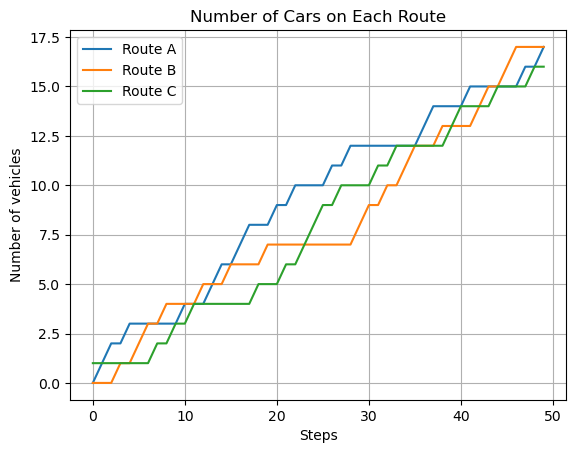

In [8]:
plt.plot([x[0] for x in road_traffics], label="Route A")
plt.plot([x[1] for x in road_traffics], label="Route B")
plt.plot([x[2] for x in road_traffics], label="Route C")

plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Number of vehicles")
plt.title("Number of Cars on Each Route")
plt.legend()
plt.show()

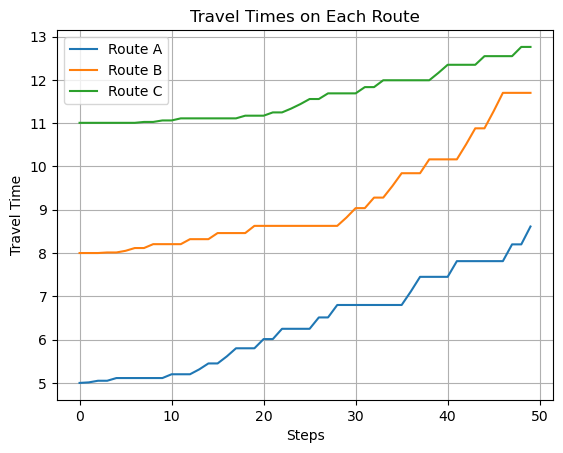

In [9]:
plt.plot([x[0] for x in travel_times], label="Route A")
plt.plot([x[1] for x in travel_times], label="Route B")
plt.plot([x[2] for x in travel_times], label="Route C")

plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Travel Time")
plt.title("Travel Times on Each Route")
plt.legend()
plt.show()

# Training

In [10]:
episode_rewards = list()
final_states = list()

start_time = time.time()

for e in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    episode_reward = 0

    for i in range(num_vehicles):
        action = agent.pick_action(state)
        next_state, reward = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state)
        agent.replay()
        episode_reward += reward

        state = next_state

    agent.decay_epsilon()

    episode_rewards.append(episode_reward)
    final_states.append((env.traffic_on_roads[0], env.traffic_on_roads[1], env.traffic_on_roads[2]))

    print("\rAt episode: %d" % (e+1), end='')
    if ((e+1) % 50 == 0) or (e == 0):
        print("\r----- Episode #%d -----\nReward: %.3f\nq_a: %d, q_b: %d, q_c: %d" % (e+1, episode_reward, env.traffic_on_roads[0], env.traffic_on_roads[1], env.traffic_on_roads[2]))


print("\n\n[COMPLETED] : %s" % (time.strftime("%H hours, %M minutes, %S seconds", time.gmtime(time.time() - start_time))))

----- Episode #1 -----
Reward: -451.650
q_a: 21, q_b: 19, q_c: 10
----- Episode #50 -----
Reward: -445.167
q_a: 21, q_b: 16, q_c: 13
----- Episode #100 -----
Reward: -470.020
q_a: 25, q_b: 18, q_c: 7
----- Episode #150 -----
Reward: -448.171
q_a: 25, q_b: 16, q_c: 9
----- Episode #200 -----
Reward: -450.057
q_a: 24, q_b: 17, q_c: 9
----- Episode #250 -----
Reward: -443.764
q_a: 22, q_b: 17, q_c: 11
----- Episode #300 -----
Reward: -441.391
q_a: 23, q_b: 15, q_c: 12
----- Episode #350 -----
Reward: -447.055
q_a: 22, q_b: 16, q_c: 12
----- Episode #400 -----
Reward: -451.673
q_a: 23, q_b: 14, q_c: 13
----- Episode #450 -----
Reward: -456.083
q_a: 21, q_b: 20, q_c: 9
----- Episode #500 -----
Reward: -447.055
q_a: 22, q_b: 16, q_c: 12


[COMPLETED] : 01 hours, 31 minutes, 15 seconds


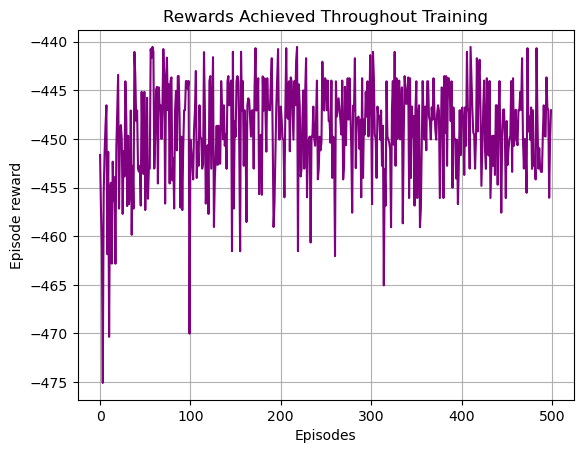

In [11]:
plt.plot(episode_rewards, color="purple")

plt.xlabel("Episodes")
plt.ylabel("Episode reward")
plt.title("Rewards Achieved Throughout Training")
plt.grid(True)
plt.show()

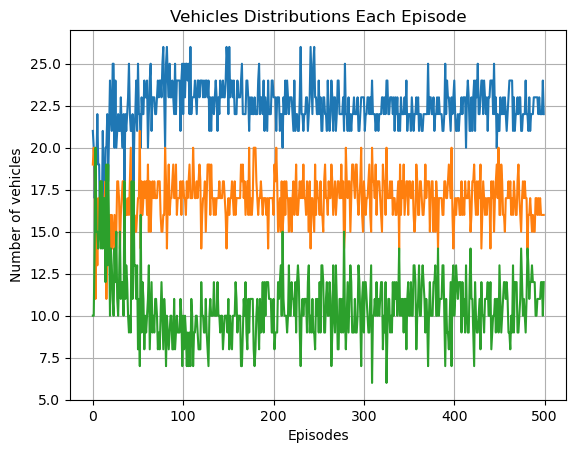

In [12]:
plt.plot([s[0] for s in final_states], label="Route A")
plt.plot([s[1] for s in final_states], label="Route B")
plt.plot([s[2] for s in final_states], label="Route C")

plt.xlabel("Episodes")
plt.ylabel("Number of vehicles")
plt.title("Vehicles Distributions Each Episode")
plt.grid(True)
plt.show()

# Testing the agent

In [13]:
agent.epsilon = 0 # Strictly follow the policy

In [14]:
road_traffics = list()
travel_times = list()

state = env.reset()
state = np.reshape(state, [1, state_size])
episode_reward = 0

for i in range(num_vehicles):
    action = agent.pick_action(state)
    next_state, reward = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    episode_reward += reward
    state = next_state

    road_traffics.append([env.traffic_on_roads[0], env.traffic_on_roads[1], env.traffic_on_roads[2]])
    travel_times.append(env.get_travel_times())

print("Total reward: %.4f" % episode_reward)
print("Final state:\nq_a: %d, q_b: %d, q_c: %d" % (env.traffic_on_roads[0], env.traffic_on_roads[1], env.traffic_on_roads[2]))

Total reward: -451.6726
Final state:
q_a: 23, q_b: 14, q_c: 13


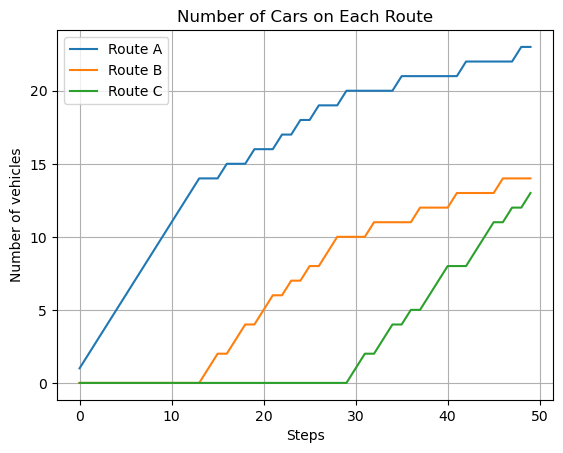

In [15]:
plt.plot([x[0] for x in road_traffics], label="Route A")
plt.plot([x[1] for x in road_traffics], label="Route B")
plt.plot([x[2] for x in road_traffics], label="Route C")

plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Number of vehicles")
plt.title("Number of Cars on Each Route")
plt.legend()
plt.show()

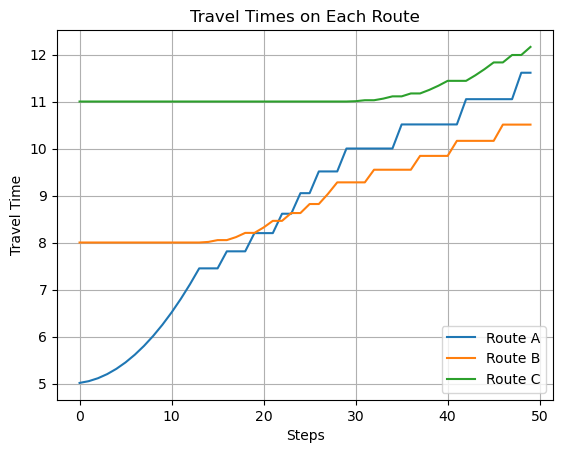

In [16]:
plt.plot([x[0] for x in travel_times], label="Route A")
plt.plot([x[1] for x in travel_times], label="Route B")
plt.plot([x[2] for x in travel_times], label="Route C")

plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Travel Time")
plt.title("Travel Times on Each Route")
plt.legend()
plt.show()

**We see that the agent does not assign more vehicles to longer free flow travel routes, until the faster one becomes congested enough.**